In [1]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from IPython.display import display, Image

%matplotlib inline

## Neural Network

In this notebook, we will work with the qm7b data.

In [2]:
qm7b = pd.read_csv('http://faculty.washington.edu/tingcao/wordpress/wp-content/uploads/2020/10/qm7b.csv');
qm7b.head()

,id,ae_pbe0,emax_zindo,imax_zindo,homo_zindo,lumo_zindo,e1_zindo,ip_zindo,ea_zindo,homo_pbe0,...,homo_gw,lumo_gw,p_pbe0,p_scs,n_H,n_C,n_N,n_O,n_S,n_Cl
0,1,-420.933746,39.694626,0.621841,-16.013,4.162,36.768073,15.72523,-3.98613,-10.9488,...,-14.1341,1.0870,2.534576,2.43222,4,1,0,0,0,0
1,2,-718.419189,22.622486,0.628328,-13.549,3.684,11.717433,13.41121,-3.49181,-9.5577,...,-12.5472,1.1186,4.332028,4.44500,6,2,0,0,0,0
2,3,-570.024841,22.940671,0.709060,-10.160,1.231,7.137266,9.75211,-0.82042,-7.8768,...,-10.4383,1.9456,4.173282,3.92308,4,2,0,0,0,0
3,4,-410.286163,15.973798,2.228480,-10.706,2.145,4.624107,10.46577,-1.89847,-8.4021,...,-11.1629,1.1958,3.512394,3.32175,2,2,0,0,0,0
4,5,-868.855408,17.900516,0.556174,-12.365,3.825,10.311655,11.96491,-3.57487,-8.3534,...,-10.8132,1.2002,5.480160,5.78632,6,3,0,0,0,0


Let our predictors be 'homo_zindo', 'lumo_zindo', target be 'e1_zindo' (first excitation energy).

Do the train-test splitting first.

In [3]:
x = qm7b[['homo_zindo', 'lumo_zindo']].values  # predictors
y = qm7b['e1_zindo'].values  # target
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.20,
                                                    random_state=111)

## Data Standardization

The `StandardScaler` standardize the data by: $X_i = \frac{X_i - \mu _i}{\sigma _i}$,

$X_i$ is the $i$-th feature, $\mu_i$ is the mean value of the feature $i$ in the training data, $\sigma_i$ is the variance of the feature $i$ in the training data.

In [4]:
scaler = StandardScaler().fit(x_train)  # to find the mean value and variance og the training data set
x_train_norm = scaler.transform(x_train)  # normalized training data
x_test_norm = scaler.transform(x_test)  # normalized testing data

Histogram before normalization:

(array([ 19.,  33.,  97., 249., 304., 268.,  87.,  88., 256.,  42.]),
 array([-2.284 , -1.6731, -1.0622, -0.4513,  0.1596,  0.7705,  1.3814,
         1.9923,  2.6032,  3.2141,  3.825 ]),
 <BarContainer object of 10 artists>)

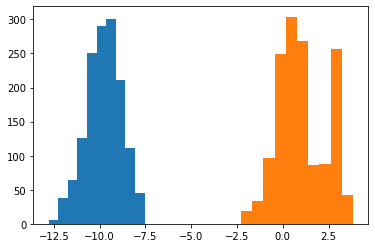

In [5]:
plt.hist(x_test[:,0])
plt.hist(x_test[:,1])

Histogram after normalization:

(array([ 19.,  33.,  97., 249., 304., 268.,  87.,  88., 256.,  42.]),
 array([-2.5437301 , -2.0774628 , -1.6111955 , -1.1449282 , -0.67866089,
        -0.21239359,  0.25387371,  0.72014101,  1.18640831,  1.65267562,
         2.11894292]),
 <BarContainer object of 10 artists>)

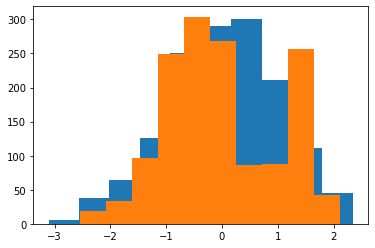

In [6]:
plt.hist(x_test_norm[:,0])
plt.hist(x_test_norm[:,1])




## Train and test neural network

We construct a neural network model with one input layer, one hidden layer and one output layer, and wrap it in a function.

The picture below illustrates the structure of neural network:

<img width="512" alt="NN" src="https://www.astroml.org/_images/fig_neural_network_1.png"></a>


Here we set each layer in the neural network to be `dense` layer. A `Dense` function implements the operation: `output = activation(dot(input, kernel) + bias)` 

where `activation` is the element-wise activation function passed as the activation argument (shown as $f(),g()$ in the picture), `kernel` is a weights matrix created by the layer (shown as $w_{ij}, w_{jk}$ in the picture), and `bias` is a bias vector created by the layer (shown as $b_j,b_k$ in the picture).


In [7]:
#Define a neural network model, and wrap this model in a function
def nnmodel1():
    model = Sequential()  # to specify that the neural network has to be a sequential one
    
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

After we define the neural network model, we will need to train it.

* `epochs`: specify the number of epochs. In each epoch, ALL the training data will be propagated through the network once.
* `batch_size`: the number of samples that will be propagated through the network in a batch. The weights in the network will be updated after each batch (this might depend the optimization algorithm you choose).
* `validation_split`: split the given ratio of training data into validation data, the rest is training data. Note that only the training data will be used to train the model, the validation data is just used for evaluate the accuracy of the model after each epoch. 

The overall process of training:

    For each epoch:
        For each batch:
            For each training data in the batch:
                propagate through the network
            Update the weights
            Get the accuracy of training dataset
        For each validation data in the batch:
            Get the accuracy of validation dataset
            

In [8]:
# np.random.seed(111)
estimator = KerasRegressor(build_fn=nnmodel1) #nnmodel1 is the neural network model we defined above
history = estimator.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

2022-11-20 23:04:31.862957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 23:04:31.944858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-20 23:04:31.945732: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


After we train the model, we can plot the train and validation error in each epoch of training. This plot is called `learning curve`.

In [9]:
history.history

{'loss': [33.85589599609375,
  27.138206481933594,
  12.668167114257812,
  3.4551007747650146,
  1.4169262647628784,
  0.9654152989387512,
  0.8884279131889343,
  0.8796069622039795,
  0.8776477575302124,
  0.8779284358024597,
  0.8756386637687683,
  0.8746445178985596,
  0.8723524808883667,
  0.871158242225647,
  0.8706158399581909,
  0.8687270283699036,
  0.8657941222190857,
  0.8639244437217712,
  0.8618634343147278,
  0.8604869246482849],
 'val_loss': [30.98375129699707,
  19.737051010131836,
  5.809046268463135,
  1.7620443105697632,
  0.8967539668083191,
  0.7257398366928101,
  0.6986331939697266,
  0.6995475888252258,
  0.7034256458282471,
  0.6995846629142761,
  0.6991456151008606,
  0.6904900074005127,
  0.692767858505249,
  0.691336452960968,
  0.6902995109558105,
  0.6884052753448486,
  0.6813554763793945,
  0.6788764595985413,
  0.6786254644393921,
  0.6733695268630981]}

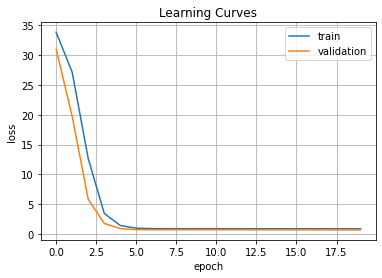

In [10]:
plt.plot(range(20),history.history['loss'])
plt.plot(range(20),history.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

The learning curve can be used to diagnose if the model is `Good fit`,`Under fit` or `Over fit`. It can indicate a `Good fit` if the training curve decreases to a point of stability and have a stable gap with the validation curve. A `Over fit` can be inferred if the training curve constantly decreases while the validation curve remains flat or even increases. A `Under fit` can be identified if the training curve is decreasing and continues to decrease at the end of the training process.

In [11]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 0.86 and for validation is 0.67


Test the neural network:

In [12]:
test_loss = estimator.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss)

46/46 [==============================] - 0s 663us/step - loss: 0.7833
test set mse is 0.78


Predict with the neural network:

In [13]:
y_test_predict = estimator.predict(x_test_norm)

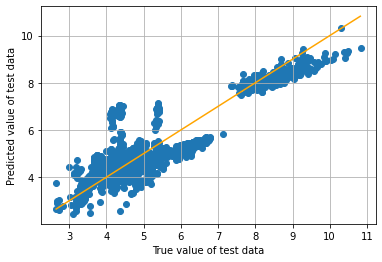

In [14]:
plt.scatter(y_test, y_test_predict)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

## Tune the neural network

### Tune the activation function

Three types of activation functions `ReLu` `Sigmoid` and `Tanh` are plotted below. By using different activation functions in different layers, you could allow the model to have more complex mappings between the inputs and outputs.

A full list of available activation functions in Keras can be found here: https://keras.io/api/layers/activations/ .

In our example, you can set the activation function of each layer by the parameter `activation` in the `Dense()` function. 

(-5.0, 5.0, -1.2, 1.2)

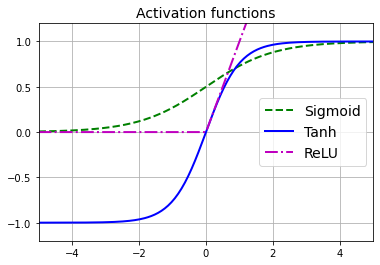

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")

plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

### Exercise 1: 
Please define a new neural network model by simply changing the parameter `activation` in the HIDDEN LAYER of the `nnmodel1()` from `relu` to another activation function of your choice, and do the train,test again.
Is your result improved compared to `nnmodel1()` in terms of test error?

In [16]:
# from relu to selu

def nnmodel2():
    model = Sequential()  # to specify that the neural network has to be a sequential one
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='selu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [17]:
# np.random.seed(111)
estimator = KerasRegressor(build_fn=nnmodel2) #nnmodel1 is the neural network model we defined above
history1 = estimator.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

In [18]:
history1.history

{'loss': [33.75611877441406,
  25.549636840820312,
  10.225021362304688,
  2.1612305641174316,
  1.239025354385376,
  1.2160083055496216,
  1.2081080675125122,
  1.1998600959777832,
  1.1881004571914673,
  1.1771150827407837,
  1.1638692617416382,
  1.1478793621063232,
  1.1305395364761353,
  1.1118429899215698,
  1.0914777517318726,
  1.0751241445541382,
  1.0564343929290771,
  1.039564609527588,
  1.0241507291793823,
  1.0127590894699097],
 'val_loss': [30.467939376831055,
  17.111677169799805,
  3.7635691165924072,
  1.0480844974517822,
  0.9861724376678467,
  0.9801957607269287,
  0.9753543138504028,
  0.9649848341941833,
  0.9486177563667297,
  0.9390430450439453,
  0.9202563762664795,
  0.9028618931770325,
  0.8877124786376953,
  0.8651706576347351,
  0.8404973745346069,
  0.8231194615364075,
  0.8055408596992493,
  0.7904713749885559,
  0.7790210843086243,
  0.7686063647270203]}

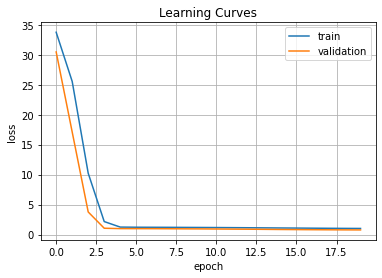

In [19]:
plt.plot(range(20),history1.history['loss'])
plt.plot(range(20),history1.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [20]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history1.history['loss'][-1], history1.history['val_loss'][-1]))

final MSE for train is 1.01 and for validation is 0.77


In [21]:
test_loss = estimator.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss)

46/46 [==============================] - 0s 681us/step - loss: 0.8827
test set mse is 0.88


In [22]:
y_test_predict = estimator.predict(x_test_norm)

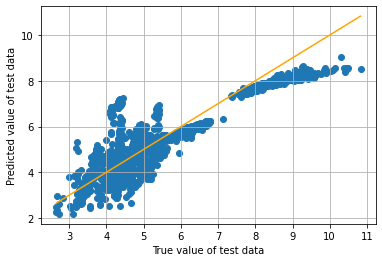

In [23]:
plt.scatter(y_test, y_test_predict)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

In Exercise 1, I used the Scaled Exponential Linear Unit (SELU) as my activation function. The result showed that my result is much worse compared to nnmodel1() in terms of test error. (0.84 > 0.64)

### Tune learning rate of the optimizer

The training of neural network can be regarded as an optimization process of searching the minimum of the loss function. Imagine you're searching a fastest way of going down a mountain (i.e. searching the 'minimum' of the mountain), one strategy you can take is going along the direction with the steepest descent of height. And after going one step in that direction, you need to determine the new steepest descent since your location is updated. This is basically the main idea of the optimization algorithm, and the size of the step you take in each time of updating the location is called `learning rate`.

<img width="512" alt="Trajectory towards local minimum" src="https://miro.medium.com/max/1400/1*70f9PB-RwFaakqD6lfp4iw.png"></a>

The `Adam` optimization we use here is a stochastic gradient descent method. The learning rate can be specified by the parameter `lr` in the `keras.optimizers.Adam()`. The default value is 0.001, let's change it to 0.1.

For all the available optimizers in Keras, please see this page: https://keras.io/api/optimizers/

In [24]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.1)  # to specify the learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [25]:
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

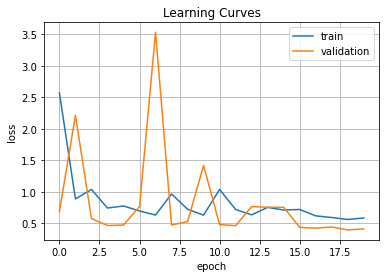

In [26]:
plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [27]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))

final MSE for train is 0.59 and for validation is 0.41


In [28]:
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

46/46 [==============================] - 0s 649us/step - loss: 0.4498
test set mse is 0.45


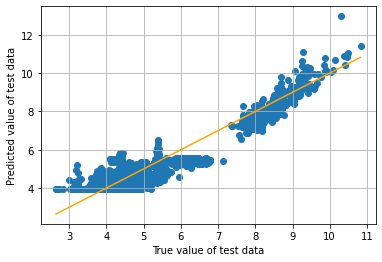

In [29]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

### Exercise 2:
* Please try some other learning rate value. Is it always better to have larger learning rate? Please explain. 

In [30]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.4)  # to specify the learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [31]:
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

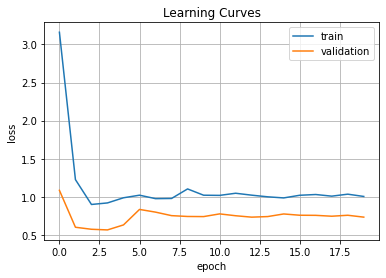

In [32]:
plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [33]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))

final MSE for train is 1.01 and for validation is 0.73


In [34]:
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

46/46 [==============================] - 0s 684us/step - loss: 0.7738
test set mse is 0.77


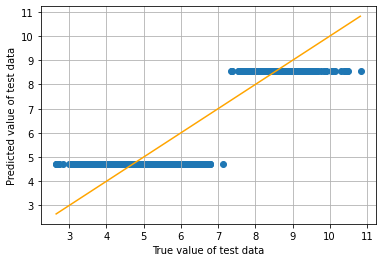

In [35]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

Learning rate is a hyper-parameter that controls the weights of our neural network with respect to the loss gradient. It defines how quickly the neural network updates the concepts it has learned.

In setting a learning rate, there is a trade-off between the rate of convergence and overshooting. While the descent direction is usually determined from the gradient of the loss function, the learning rate determines how big a step is taken in that direction. A too high learning rate will make the learning jump over minima but a too low learning rate will either take too long to converge or get stuck in an undesirable local minimum

In the exercise, I change the learning from 0.1 to 1, and the testing error becomes higher.

<img width="1024" alt="Trajectory towards local minimum" src="https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png"></a>


Source:https://en.wikipedia.org/wiki/Learning_rate

 Tune the number of layers
### Exercise 3: 
* Please add an extra hidden layer to the `nnmodel3`(the new layer will be right before the output layer).  The number of neurons, kernal initializer, and activation function of the new layer are up to your choice. Train the new model on the training data, and evaluate: final mse for train,validation, test set mse. Plot the learning curves, and analyze if your model is goodfit,overfit or underfit.  Make a scatter plot of predicted value of test data vs. true value of test data. 

In [36]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.1)  # to specify the learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [37]:
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

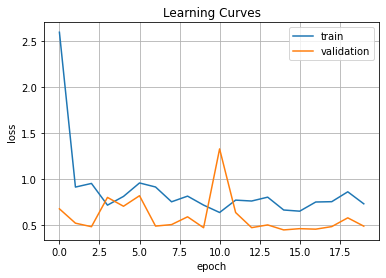

In [38]:
plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

The learning curves above show that the training curve decreases to a point of stability and have a stable gap with the validation curve, so it the model is a good fit.

In [39]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))

final MSE for train is 0.73 and for validation is 0.49


In [40]:
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

46/46 [==============================] - 0s 672us/step - loss: 0.5324
test set mse is 0.53


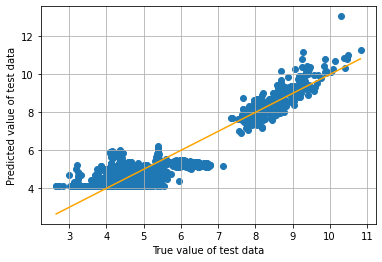

In [41]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

### Resources:

* You may have noticed that the result is changing everytime even when you train the same model with the same data. 
You will need to set up some random seeds (shown below) to make the training process completely reproducible(i.e. to make the training loss and test mse exactly the same every time you run it). (You can refer to this page for more details: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development )


In [42]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

* How to use Learning Curves to Diagnose Machine Learning Model Performance: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

* For more details about the Gradient Descent algorithm and learning rate, you can check out this article: https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3